In this blog post, I will review the famous long short-term memory (LSTM) model and try to understand how it is implemented in Keras. If you know nothing about recurrent deep learning model, please read my [previous post about recurrent neural network](https://fairyonice.github.io/Understand-Keras's-RNN-behind-the-scenes-with-a-sin-wave-example.html). If you know reccurent neural network (RNN) but not LSTM, you should first read [Colah's great blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). The LSTM outperforms Simple RNN model because it is designed to remember longer time series. 

In this blog, I will discuss: 

- how to fit a LSTM model to predict a point in time series given another time series.
- how to extract weights for forget gates, input gates and output gates from the LSTM's model.
- how to calculate hidden and cell states from the weight outputs.

To start learning LSTM, let's create a synthetic time series data. Having a data in front help understood the meaning of each parameter in LSTM.


In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import seaborn as sns
import pandas as pd
import sys, time
import numpy as np
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "1"
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)


python 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
keras version 2.1.3
tensorflow version 1.5.0


## Create synthetic long time series data

I will generate a time series $X_{t}$ ($t=1,...,T$) as my independent feature.
As the target, or dependent time series, I will create a time series $Y_{t}$ as a function of a single time series $\{ X_{k} \}_{k=1}^t$.


Given integers $D$ and $T$, the time series $X_{t}$ an $Y_t$ are generated as:

$$
C \sim \textrm{Multinomial}(5,6,...,99)\\
U \sim \textrm{Unif}([0,1])\\
X_{t} = -\frac{t}{T}U\left[ \textrm{Cos}\left(\frac{t}{1+C}\right) \right]\\
Y_{t} = X_{t-2} X_{t-\textrm{D}} \textrm{ for t > D else } Y_t = 0 
$$

We consider a long time series $T = 1,000$. 

The parameter $D$ determines the time lag. The larger $D$ is, the longer it takes for the $Y_{t}$ to show the effect of $X_{t}$, and the longer memory that the deep learning model needs to remember. For this exercise, I will consider $D=10$, and generate 1,000 sets of time series, independently.

Plot examples of the generated time series.

- The frequency of the waves vary across samples.
- The first 10 $Y_t$ are set to zero ($Y_1=...=Y_{10} = 0$)

In [40]:

def random_sample(len_ts=3000,D=1001):
    c_range = range(5,100)
    c1 = np.random.choice(c_range)
    u = np.random.random(1)
    const = -1.0/len_ts
    ts = np.arange(0,len_ts)
    
    x1 = np.cos(ts/float(1.0 + c1))
    x1 = x1*ts*u*const
    
    y1 = np.zeros(len_ts)

    for t in range(D,len_ts):
        ## the output time series depend on input as follows: 
        y1[t] = x1[t-2]*x1[t-D] 
    y = np.array([y1]).T
    X = np.array([x1]).T
    return y, X
def generate_data(D= 1001,Nsequence = 1000,T=4000, seed=123):
    X_train = []
    y_train = []
    set_seed(sd=seed)
    for isequence in range(Nsequence):
        y, X = random_sample(T,D=D)
        X_train.append(X)
        y_train.append(y)
    return np.array(X_train),np.array(y_train)

D = 10
T = 1000
X, y = generate_data(D=D,T=T,Nsequence = 1000)
print(X.shape, y.shape)

((1000, 1000, 1), (1000, 1000, 1))


Plot examples of the generated time series.

- The frequency of the waves vary across samples.
- The first 10 $Y_t$ are set to zero ($Y_1=...=Y_{10} = 0$)

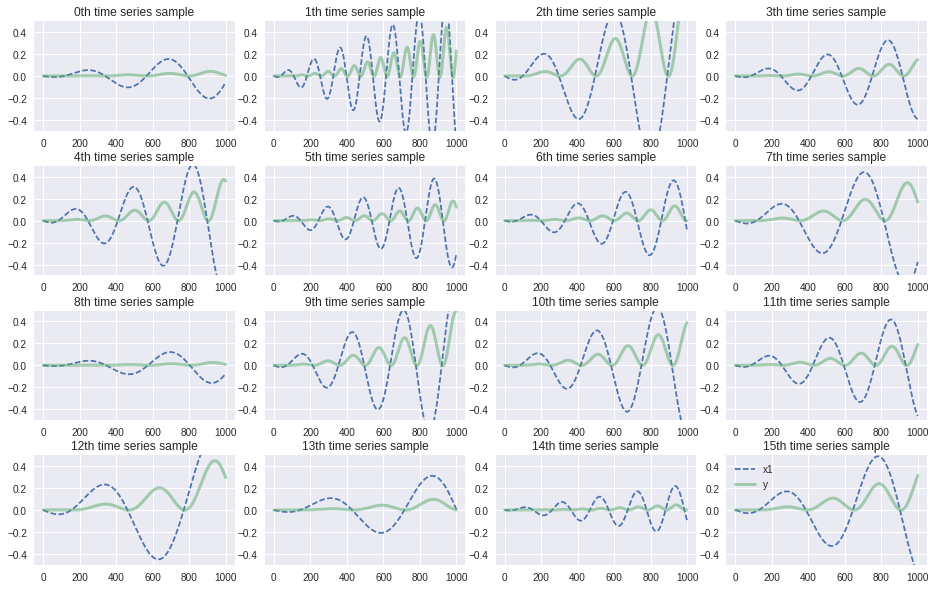

In [41]:
def plot_examples(X,y,ypreds=None,nm_ypreds=None):
    fig = plt.figure(figsize=(16,10))
    fig.subplots_adjust(hspace = 0.32,wspace = 0.15)
    count = 1
    n_ts = 16
    for irow in range(n_ts):
        ax = fig.add_subplot(n_ts/4,4,count)
        ax.set_ylim(-0.5,0.5)
        ax.plot(X[irow,:,0],"--",label="x1")
        ax.plot(y[irow,:,:],label="y",linewidth=3,alpha = 0.5)
        ax.set_title("{:}th time series sample".format(irow))
        if ypreds is not None:
            for ypred,nm in zip(ypreds,nm_ypreds):
                ax.plot(ypred[irow,:,:],label=nm)   
        count += 1
    plt.legend()
    plt.show()
plot_examples(X,y,ypreds=None,nm_ypreds=None)

## LSTM model
I create a LSTM model to predict $Y_t$ using the time series $X_k, k=1,...,t$ (t=1,...,1,000).

### Difference with RNN model
The RNN layer updates the hidden states $h_t$ in a simple formula with two unknown weights and a bias, $w_{1x}$, $w_{1h}$ and $b_1$ given the previous hidden state $h_{t-1}$ and input $x_t$. The update process can be written in a single line as:

$$
h_t = \textrm{tanh}(x_t^T w_{1x} + h_{t-1}^T w_{1h} + b_1)
$$

The hidden state $h_t$ is passed to the next cell as well as the next layer as inputs.

The LSTM model also have hidden states that are updated between recurrent cells. In fact, the LSTM layer has two types of states: hidden state and cell states that are passed between the LSTM cells. However, only hidden states are passed to the next layer.

### LSTM cell formulation
Let nfeat denote the number of input time series features. In our example, nfeat = 1. Then the LSTM layer with "hunits" hidden units $h_{t} \in R^{\textrm{hunits}}$ are defined with  4(hunits x hunits + hunits x nfeat + hunits x 1) parameters:

$$
\boldsymbol{W}_i \in R^{\textrm{hunits x nfeat}}, \boldsymbol{U}_i \in R^{\textrm{hunits x hunits}},\boldsymbol{b}_i \in R^{\textrm{hunits x 1}}\\
\boldsymbol{W}_f \in R^{\textrm{hunits x nfeat}},\boldsymbol{U}_f \in R^{\textrm{hunits x hunits}},\boldsymbol{b}_f \in R^{\textrm{hunits x 1}}\\
\boldsymbol{W}_c \in R^{\textrm{hunits x nfeat}},\boldsymbol{U}_c \in R^{\textrm{hunits x hunits}},\boldsymbol{b}_c \in R^{\textrm{hunits x 1}}\\
\boldsymbol{W}_o \in R^{\textrm{hunits x nfeat}},\boldsymbol{U}_o \in R^{\textrm{hunits x hunits}},\boldsymbol{b}_o \in R^{\textrm{hunits x 1}}\\
$$

- input gate
$$
\boldsymbol{i}_t = \textrm{sigmoid} \left(
\boldsymbol{W}_i\boldsymbol{h}_{t-1} + \boldsymbol{U}_i\boldsymbol{x}_{t} + \boldsymbol{b}_i
\right)
$$
  - sigmoid is applied element wise.
- forget gate
$$
\boldsymbol{f}_t = \textrm{sigmoid} \left(
\boldsymbol{W}_f \boldsymbol{h}_{t-1}+ \boldsymbol{U}_f \boldsymbol{x}_{t} + \boldsymbol{b}_f
\right)
$$
  - sigmoid is applied element wise.
- new candidate cell state
$$
\boldsymbol{\tilde{c}} = \textrm{tanh} \left(
\boldsymbol{W}_c \boldsymbol{h}_{t-1}+ \boldsymbol{U}_c \boldsymbol{x}_{t} + \boldsymbol{b}_c
\right)
$$
  - tanh is applied element wise.
- output gate
$$
\boldsymbol{o}_t = \textrm{sigmoid} \left(
\boldsymbol{W}_o \boldsymbol{h}_{t-1}+ \boldsymbol{U}_o \boldsymbol{x}_{t} + \boldsymbol{b}_o
\right)
$$
  - sigmoid is applied element wise.
- cell state
$$
\boldsymbol{c}_t= \boldsymbol{f}_t * \boldsymbol{c}_{t-1} + \boldsymbol{i}_t * \boldsymbol{\tilde{c}}
$$
 - $*$ means element wise multiplication.

- hidden state
$$
\boldsymbol{h}_t= \boldsymbol{o}_t * \textrm{tanh}(\boldsymbol{c}_{t})
$$

$\boldsymbol{h}_t$ is passed as an input of higher layer.
For example in our model, we pass $\boldsymbol{h}_t$ to the fully connected layer.

I will create a single layer LSTM model with 3 nodes, followed by fully connected layer.
This model contains 60 parameters (= 4*(3*3+3*1 + 3*1) = 4(hunits x hunits + hunits x nfeat + hunits x 1)) in LSTM layer and 4 parameters in fully connected layer.

In [42]:
from keras import models 
from keras import layers

def define_model(len_ts,
                 hidden_neurons = 1,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(inp,rnn,dens))

Here I define a model.

In [43]:
X_train, y_train = X ,y
hunits = 3
model1, _ = define_model(
    hidden_neurons = hunits,
    len_ts = X_train.shape[1])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000, 1)           0         
_________________________________________________________________
RNN (LSTM)                   (None, 1000, 3)           60        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1000, 1)           4         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


For model training, we use MSE loss. As the first 10 $Y_t$ is not defined based on $X_{t}$, I will not compute the MSE for the first 10 samples and compute it only for the t = 10,...,1000.

This can be easily done in Keras by incorporating "sample_weight" in loss definition. The loss for each sample sequence is defined with weights as:

$$
Loss = \frac{1}{\sum_{t=1}^T w_t}\sum_{t=1}^T w_t (Y_t - \hat{Y}_t)^2 
$$

where $w_t = 1$ for $t>D$ and $w_t=0$ otherwise.

In [44]:
w = np.zeros(y_train.shape[:2])
w[:,D:] = 1 
w_train = w

## Model training
I will save model at every epoch using call back function.

In [45]:
from keras.callbacks import ModelCheckpoint
start = time.time()
hist1 = model1.fit(X_train, y_train, 
                   batch_size=2**9,
                   epochs=200, 
                   verbose=False,
                   sample_weight=w_train,
                   validation_split=0.05,
                   callbacks=[
                   ModelCheckpoint(filepath="weights{epoch:03d}.hdf5")])
end = time.time()
print("Time took {:3.1f} min".format((end-start)/60))

Time took 10.5 min


## The validation loss plot

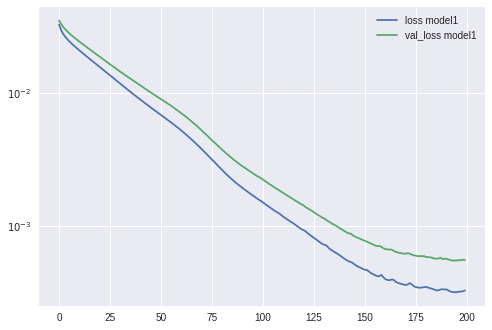

In [46]:
labels = ["loss","val_loss"]
for lab in labels:
    plt.plot(hist1.history[lab],label=lab + " model1")
plt.yscale("log")
plt.legend()
plt.show() 

## Validate the model performance with new data

In [47]:
X_test, y_test = generate_data(D=D,T=T,seed=2,
                               Nsequence = 1000)
y_pred1 = model1.predict(X_test)

w_test = np.zeros(y_test.shape[:2])
w_test[:,D:] = 1

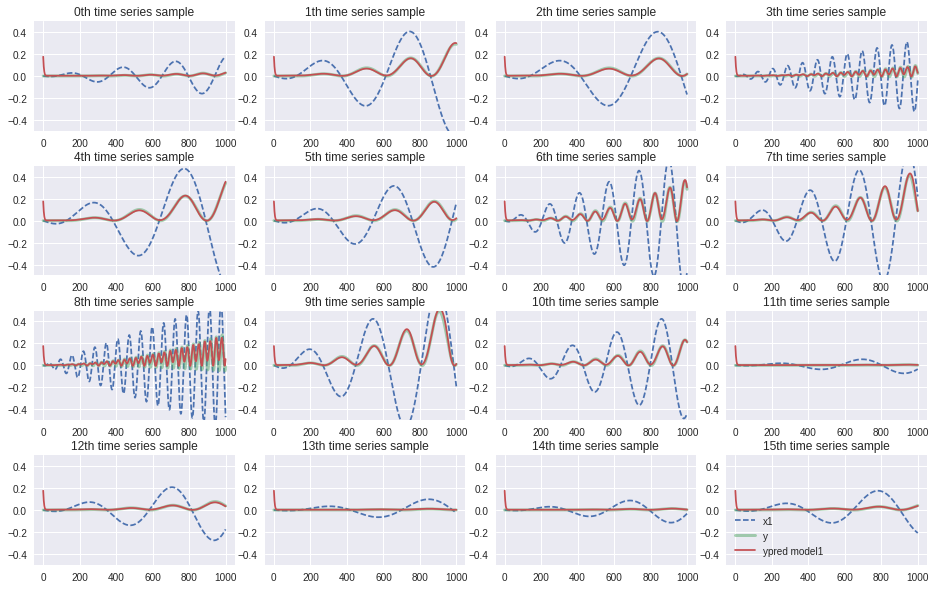

The final validation loss is 0.0003


In [48]:
plot_examples(X_test,y_test,ypreds=[y_pred1],nm_ypreds=["ypred model1"])
print("The final validation loss is {:5.4f}".format( 
    np.mean((y_pred1[w_test == 1] - y_test[w_test==1])**2 )))

## Reproduce LSTM layer outputs by hands
The best way to understand how LSTM layer calculate hidden states and cell states are to reproduce them by hands! 
We first extract the estimated weights of the LSTM layer from model1.

In [49]:
for layer in model1.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
warr.shape,uarr.shape,barr.shape

((1, 12), (3, 12), (12,))

- warr is a numpy array of weights for inputs
- uarr is a numpy array of weights for hidden units
- barr is a numpy array of bias

The following methods extract weights for input, forget and output gates, and the cell states. Then I calculate cell states and hidden states.

In [50]:
def sigmoid(x):
    return(1.0/(1.0+np.exp(-x)))
def LSTMlayer(weight,x_t,h_tm1,c_tm1):
    '''
    c_tm1 = np.array([0,0]).reshape(1,2)
    h_tm1 = np.array([0,0]).reshape(1,2)
    x_t   = np.array([1]).reshape(1,1)
    
    warr.shape = (nfeature,hunits*4)
    uarr.shape = (hunits,hunits*4)
    barr.shape = (hunits*4,)
    '''
    warr,uarr, barr = weight
    s_t = (x_t.dot(warr) + h_tm1.dot(uarr) + barr)
    hunit = uarr.shape[0]
    i  = sigmoid(s_t[:,:hunit])
    f  = sigmoid(s_t[:,1*hunit:2*hunit])
    _c = np.tanh(s_t[:,2*hunit:3*hunit])
    o  = sigmoid(s_t[:,3*hunit:])
    c_t = i*_c + f*c_tm1
    h_t = o*np.tanh(c_t)
    return(h_t,c_t)

The initial values of cell states and hidden states are zero.

In [51]:
c_tm1 = np.array([0]*hunits).reshape(1,hunits)
h_tm1 = np.array([0]*hunits).reshape(1,hunits)

We consider three time points $X_1=0.003,X_2=0.002$ and $X_3=1$ as inputs and evaluate $\boldsymbol{h_3}$ and $\boldsymbol{c_3}$: 


In [52]:
xs  = np.array([0.003,0.002,1])
for i in range(len(xs)):
    x_t = xs[i].reshape(1,1)
    h_tm1,c_tm1 = LSTMlayer(weightLSTM,x_t,h_tm1,c_tm1)
print("h3={}".format(h_tm1))
print("c3={}".format(c_tm1))

h3=[[0.15008775 0.01919995 0.1935698 ]]
c3=[[0.22576768 0.03767894 0.46717375]]


We can calculate hidden states and cell states using Keras's functional API.

In [53]:
batch_size = 1
len_ts = len(xs)
nfeature = X_test.shape[2]

inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  
rnn,s,c = layers.LSTM(hunits, 
                         return_sequences=True,
                         stateful=False,
                         return_state=True,
                         name="RNN")(inp)
states = models.Model(inputs=[inp],outputs=[s,c, rnn])

for layer in states.layers:
    for layer1 in model1.layers:
        if layer.name == layer1.name:
            layer.set_weights(layer1.get_weights())
            
h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,1))
print("h3={}".format(h_t_keras))
print("c3={}".format(c_t_keras))


h3=[[0.14217362 0.01967374 0.19257708]]
c3=[[0.22343878 0.03877562 0.45090497]]


The hidden states and cell states from Keras and from my hand calculations reasonably agree.
(But the two are not identical and I am not sure why...)

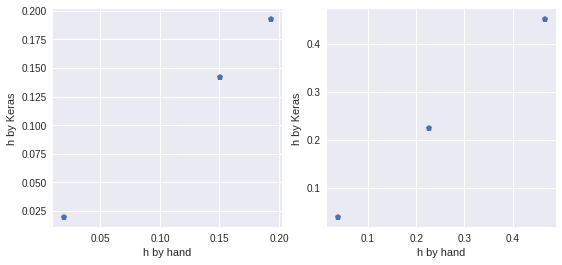

In [54]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(1,2,1)
ax.plot(h_tm1.flatten(),h_t_keras.flatten(),"p")
ax.set_xlabel("h by hand")
ax.set_ylabel("h by Keras")

ax = fig.add_subplot(1,2,2)
ax.plot(c_tm1.flatten(),c_t_keras.flatten(),"p")
ax.set_xlabel("h by hand")
ax.set_ylabel("h by Keras")
plt.show()

# Obtain weights from LSTM
[Philippe Rémy commented how to obtain weights for forgate gatesm input gates, cell states and output gates.](https://github.com/keras-team/keras/issues/1922) But this method seems outdated for the latest version of Keras. Here I try to extract LSTM weights by refering to LSTMCell definition at [Keras's reccurent.py](https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py).

In [55]:
def get_LSTM_UWb(weight):
    '''
    weight must be output of LSTM's layer.get_weights()
    W: weights for input
    U: weights for hidden states
    b: bias
    '''
    warr,uarr, barr = weight
    gates = ["i","f","c","o"]
    hunit = uarr.shape[0]
    U, W, b = {},{},{}
    for i1,i2 in enumerate(range(0,len(barr),hunit)):
        
        W[gates[i1]] = warr[:,i2:i2+hunit]
        U[gates[i1]] = uarr[:,i2:i2+hunit]
        b[gates[i1]] = barr[i2:i2+hunit].reshape(hunit,1)
    return(W,U,b)

def get_LSTMweights(model1):
    for layer in model1.layers:
        if "LSTM" in str(layer):
            w = layer.get_weights()
            W,U,b = get_LSTM_UWb(w)
            break
    return W,U,b
def vectorize_with_labels(W,U,b):
    bs,bs_label,ws,ws_label,us,us_label=[],[],[],[],[],[]
    for k in ["i","f","c","o"]:
        temp = list(W[k].flatten())
        ws_label.extend(["W_"+k]*len(temp))
        ws.extend(temp)

        temp = list(U[k].flatten())
        us_label.extend(["U_"+k]*len(temp))
        us.extend(temp)    

        temp = list(b[k].flatten())
        bs_label.extend(["b_"+k]*len(temp))
        bs.extend(temp)  
    weight = ws + us + bs
    wlabel = ws_label + us_label + bs_label
    return(weight,wlabel)

Weights at every 10 epochs are plotted.
The weights seem to converge stably.

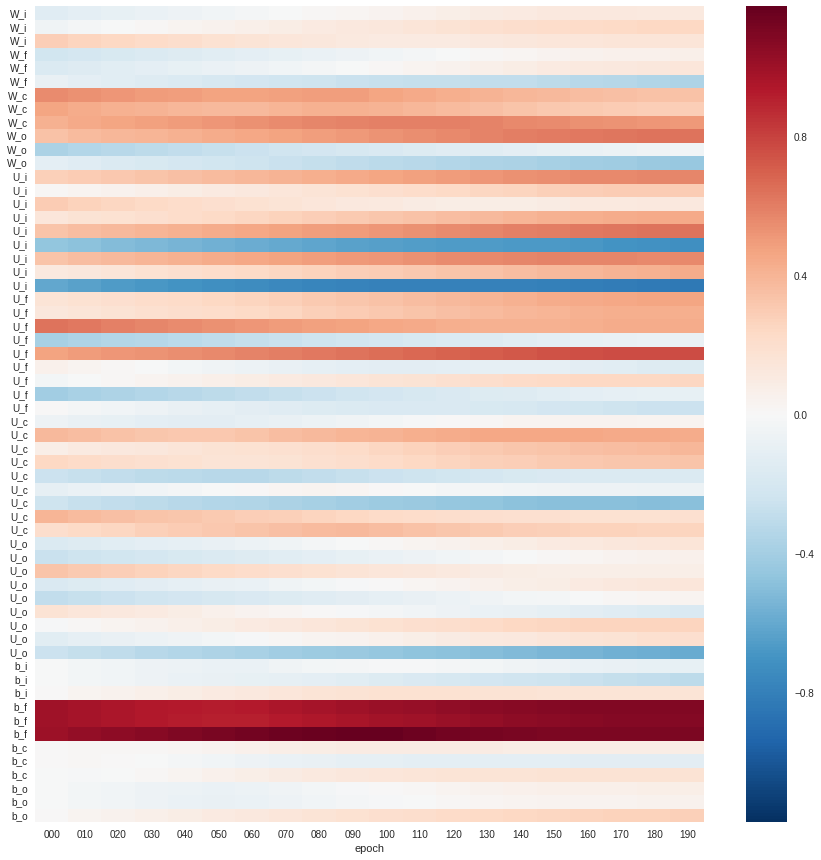

In [56]:
from copy import copy
df = {}
for epoch in np.arange(0,200,10):
    model1.load_weights("weights{:03d}.hdf5".format(epoch+1))
    WUb = get_LSTMweights(model1)
    weight,wlabel = vectorize_with_labels(*WUb)
    df["{:03d}".format(epoch)] = copy(weight)

df = pd.DataFrame(df,index=wlabel)
df = df[np.sort(df.columns)]

plt.figure(figsize=(15,15))
sns.heatmap(df)
plt.xlabel('epoch')
plt.show()
